# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import mythinkstats as mts
import numpy as np
import pandas as pd
import random

print('Ready')

Ready


## Hypothesis testing

The following is a version of `thinkstats2.HypothesisTest` with just the essential methods:

In [2]:
# Removed in favor of writing the hypothesis tests froms scratch.

And here's an example that uses it to compute the p-value of an experiment where we toss a coin 250 times and get 140 heads.

In [3]:
# Removed in favor of writing the hypothesis tests froms scratch.

The p-value turns out to be about 7%, which is considered on the border of statistical significance.

Pr(diff >= 30) = 0.07900000


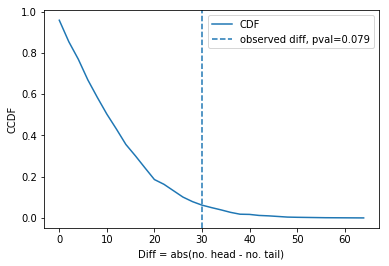

In [4]:
np.random.seed(1)

# Define the observed number of heads, tails, and their diff.
obs_head, obs_tail = 140, 110
obs_diff = abs(obs_head - obs_tail)

# Simulate the null hypothesis.
iters = 1000
phead_h0 = 0.5
sim_flip = np.random.binomial(1, phead_h0, size=(iters, obs_head + obs_tail))
sim_head = sim_flip.sum(axis=1)
sim_tail = (1 - sim_flip).sum(axis=1)
sim_diff = abs(sim_head - sim_tail)

# Compute a PMF and CDF from the diff of each simulation.
sim_diff_pmf = pd.Series(sim_diff).value_counts(normalize=True)
sim_diff_cdf = mts.pmf_to_cdf(sim_diff_pmf)
sim_diff_pmf, sim_diff_cdf, mts.cdf_percentile(sim_diff_cdf, 20)

# Compute P-value
pval = mts.cdf_pvalue(sim_diff_cdf, obs_diff)
print('Pr(diff >= %d) = %.8lf' % (obs_diff, pval))

plt.plot(sim_diff_cdf.index, 1 - sim_diff_cdf.values, label='CDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('Diff = abs(no. head - no. tail)')
plt.ylabel('CCDF')
plt.legend()
plt.show()

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [5]:
# The idea is that your simulation approximates a distribution of 
# differences under the null hypothesis by repeatedly randomly
# splitting the data into two groups and computes the difference
# in means between them. This is convenient because it removes
# the need to pick/estimate a distribution for diffs.

Here's an example where we test the observed difference in pregnancy length for first babies and others.

In [6]:
preg = mts.nsfg_read_data('ThinkStats2/code/2002FemPreg.dct', 'ThinkStats2/code/2002FemPreg.dat.gz')
live = preg[preg.outcome == 1]
first = live[live.birthord == 1]
other = live[live.birthord > 1]
len(live), len(first), len(other)

(9148, 4413, 4735)

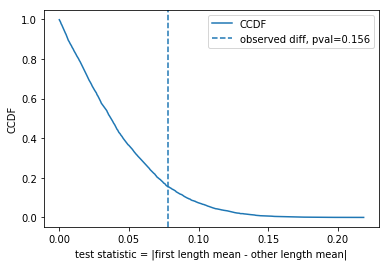

In [7]:
# Compute the observed difference in mean pregnancy length.
obs_diff = abs(first.prglngth.mean() - other.prglngth.mean())

# Simulate the PMF and CDF over diffs for the null hypothesis by repeatedly
# splitting *all* birth weights in half and computing the diffs.
iters = 5000
sim_diffs = []
for _ in range(iters):
    sample = live.prglngth.sample(len(live))
    sim_diffs.append(
        abs(sample[:len(live) // 2].mean() -
            sample[len(live) // 2:].mean()))

sim_diff_pmf = pd.Series(sim_diffs).value_counts(normalize=True)
sim_diff_cdf = mts.pmf_to_cdf(sim_diff_pmf)

# Compute P-value = CCDF(obs_diff)
pval = mts.cdf_pvalue(sim_diff_cdf, obs_diff)

plt.plot(sim_diff_cdf.index, 1 - sim_diff_cdf.values, label='CCDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('test statistic = |first length mean - other length mean|')
plt.ylabel('CCDF')
plt.legend()
plt.show()

The p-value is about 17%, which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.

Here's the distrubution of the test statistic (the difference in means) over many simulated samples:

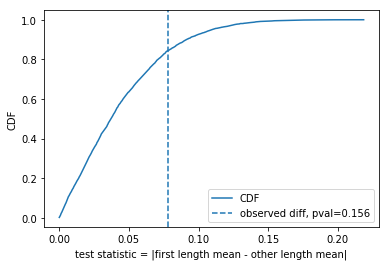

In [8]:
# Plotting the CDF instead of the CCDF.
plt.plot(sim_diff_cdf.index, sim_diff_cdf.values, label='CDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('test statistic = |first length mean - other length mean|')
plt.ylabel('CDF')
plt.legend()
plt.show()

Under the null hypothesis, we often see differences bigger than the observed difference.

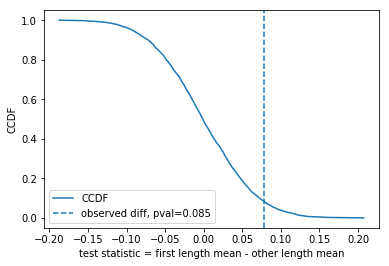

In [9]:
# This time a one sided test to check if first babies are born late.
# The p-value is about half of its previous value.
obs_diff = first.prglngth.mean() - other.prglngth.mean()

# Simulate the PMF and CDF over diffs for the null hypothesis by repeatedly
# splitting *all* birth weights in half and computing the diffs.
iters = 5000
sim_diffs = []
for _ in range(iters):
    sample = live.prglngth.sample(len(live))
    sim_diffs.append(
            sample[:len(live) // 2].mean() -
            sample[len(live) // 2:].mean())

sim_diff_pmf = pd.Series(sim_diffs).value_counts(normalize=True)
sim_diff_cdf = mts.pmf_to_cdf(sim_diff_pmf)

# Compute P-value = CCDF(obs_diff)
pval = mts.cdf_pvalue(sim_diff_cdf, obs_diff)

plt.plot(sim_diff_cdf.index, 1 - sim_diff_cdf.values, label='CCDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('test statistic = first length mean - other length mean')
plt.ylabel('CCDF')
plt.legend()
plt.show()

If the hypothesis under test is that first babies come late, the appropriate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference.  In that case, the p-value is smaller, because we are testing a more specific hypothesis.

But in this example, the result is still not statistically significant.

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

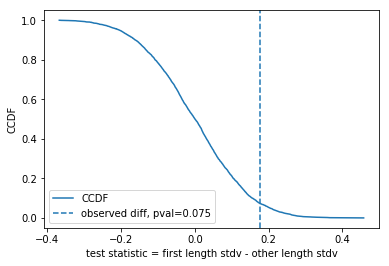

In [10]:
# Similarl one-sided test for difference in standard deviations.
obs_diff = first.prglngth.std() - other.prglngth.std()

# Simulate the PMF and CDF over diffs for the null hypothesis by repeatedly
# splitting *all* birth weights in half and computing the diffs.
iters = 5000
sim_diffs = []
for _ in range(iters):
    sample = live.prglngth.sample(len(live))
    sim_diffs.append(
            sample[:len(live) // 2].std() -
            sample[len(live) // 2:].std())

sim_diff_pmf = pd.Series(sim_diffs).value_counts(normalize=True)
sim_diff_cdf = mts.pmf_to_cdf(sim_diff_pmf)

# Compute P-value = CCDF(obs_diff)
pval = mts.cdf_pvalue(sim_diff_cdf, obs_diff)

plt.plot(sim_diff_cdf.index, 1 - sim_diff_cdf.values, label='CCDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('test statistic = first length stdv - other length stdv')
plt.ylabel('CCDF')
plt.legend()
plt.show()

But that's not statistically significant either.

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

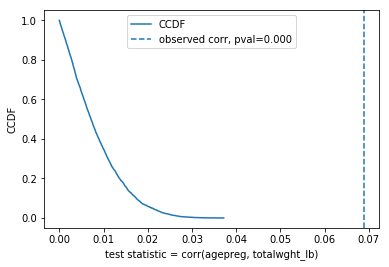

In [11]:
# Permutation test for correlation between birth weight and mother's age.
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
obs_corr = abs(mts.pearson_correlation(live.agepreg, live.totalwgt_lb))

# Simulate the PMF and CDF of correlations by repeatedly permuting
# one of the variables and re-computing correlations.
iters = 5000
sim_corrs = []
for _ in range(iters):
    sim_corrs.append(abs(mts.pearson_correlation(
        live.agepreg.sample(frac=1), live.totalwgt_lb)))

sim_corr_pmf = pd.Series(sim_corrs).value_counts(normalize=True)
sim_corr_cdf = mts.pmf_to_cdf(sim_corr_pmf)

# Compute P-value = CCDF(obs_diff)
pval = mts.cdf_pvalue(sim_corr_cdf, obs_corr)

plt.plot(sim_corr_cdf.index, 1 - sim_corr_cdf.values, label='CCDF')
plt.axvline(obs_corr, linestyle='--', label='observed corr, pval=%.3lf' % pval)
plt.xlabel('test statistic = corr(agepreg, totalwght_lb)')
plt.ylabel('CCDF')
plt.legend(loc='upper center')
plt.show()

Here's an example testing the correlation between birth weight and mother's age.

The reported p-value is 0, which means that in 1000 trials we didn't see a correlation, under the null hypothesis, that exceeded the observed correlation.  That means that the p-value is probably smaller than $1/1000$, but it is not actually 0.

To get a sense of how unexpected the observed value is under the null hypothesis, we can compare the actual correlation to the largest value we saw in the simulations.

## Testing proportions

Here's an example that tests whether the outcome of a rolling a six-sided die is suspicious, where the test statistic is the total absolute difference between the observed outcomes and the expected long-term averages.

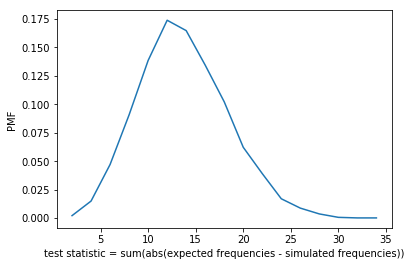

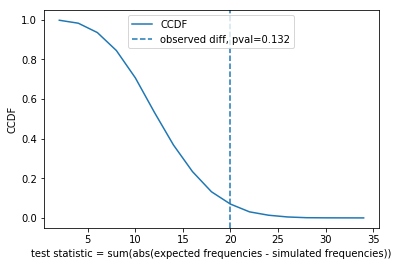

In [12]:
from collections import Counter

# Expected frequencies for a fair dice.
rolls = 60
exp_freqs = np.ones(6) * (rolls // 6)

# The observed frequencies from 60 rolls.
obs_freqs = np.array([8, 9, 19, 5, 8, 11])
obs_diff = sum(abs(obs_freqs - exp_freqs))

# The null hypothesis says that each number is equally likely.
# Simulate doing 60 rolls with fair dice and compute the absolute
# diference between the observed frequencies and the null hypothesis
# frequencies.
iters = 10000
sim_diffs = []
for _ in range(iters):
    sim_rolls = np.random.randint(1, 7, rolls)
    sim_freqs = Counter(sim_rolls.round())
    sim_freqs = np.array([sim_freqs[i+1] for i in range(6)])
    sim_diffs.append(sum(abs(sim_freqs - exp_freqs)))

# Compute PMF and CDF for null hypothesis.
sim_diff_pmf = pd.Series(sim_diffs).value_counts(normalize=True).sort_index()
sim_diff_cdf = mts.pmf_to_cdf(sim_diff_pmf)

# P-value is the CCDF of the observed differences.
pval = mts.cdf_pvalue(sim_diff_cdf, obs_diff)

plt.plot(sim_diff_pmf.index, sim_diff_pmf.values)
plt.xlabel('test statistic = sum(abs(expected frequencies - simulated frequencies))')
plt.ylabel('PMF')
plt.show()

plt.plot(sim_diff_cdf.index, 1 - sim_diff_cdf.values, label='CCDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('test statistic = sum(abs(expected frequencies - simulated frequencies))')
plt.ylabel('CCDF')
plt.legend(loc='upper center')
plt.show()

Here's an example using the data from the book:

In [13]:
# Very similar result.

The observed deviance from the expected values is not statistically significant.

By convention, it is more common to test data like this using the chi-squared statistic:

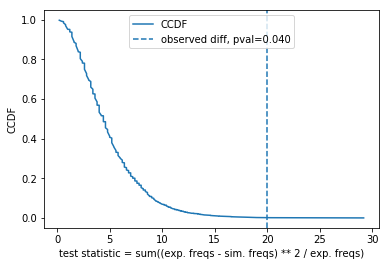

In [14]:
# Same as the previous, but this time using chi-squared statistic
# instead of absolute difference to compare frequencies.
from collections import Counter

# Expected frequencies for a fair dice.
rolls = 60
exp_freqs = np.ones(6) * (rolls // 6)

# The observed frequencies from 60 rolls.
obs_freqs = np.array([8, 9, 19, 5, 8, 11])
obs_chi2 = sum((obs_freqs - exp_freqs) ** 2 / exp_freqs)

# The null hypothesis says that each number is equally likely.
# Simulate doing 60 rolls with fair dice and compute the absolute
# diference between the observed frequencies and the null hypothesis
# frequencies.
iters = 10000
sim_chi2s = []
for _ in range(iters):
    sim_rolls = np.random.randint(1, 7, rolls)
    sim_freqs = Counter(sim_rolls.round())
    sim_freqs = np.array([sim_freqs[i+1] for i in range(6)])
    sim_chi2s.append(
        sum((sim_freqs - exp_freqs) ** 2 / exp_freqs))

# Compute PMF and CDF for null hypothesis.
sim_chi2_pmf = pd.Series(sim_chi2s).value_counts(normalize=True)
sim_chi2_cdf = mts.pmf_to_cdf(sim_chi2_pmf)

# P-value is the CCDF of the observed differences.
pval = mts.cdf_pvalue(sim_chi2_cdf, obs_chi2)

plt.plot(sim_chi2_cdf.index, 1 - sim_chi2_cdf.values, label='CCDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('test statistic = sum((exp. freqs - sim. freqs) ** 2 / exp. freqs)')
plt.ylabel('CCDF')
plt.legend(loc='upper center')
plt.show()

Using this test, we get a smaller p-value:

Taking this result at face value, we might consider the data statistically significant, but considering the results of both tests, I would not draw any strong conclusions.

## Chi-square test of pregnancy length

In [15]:
# Implemented below

If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [16]:
# Use ALL of the combined pregnancies to determine the probability
# of pregnancies in the [35, 43] interval. This was rather subtle
# in the book but I figured it out from Downey's notebook.
live_pmf = live.prglngth.value_counts(normalize=True)
X = list(range(35, 44))

# Compute the Chi-squared test statistic for both groups and sum them.
first_hist = first.prglngth.value_counts()
other_hist = other.prglngth.value_counts()
obs_X2_first = sum((live_pmf[x] * len(first) - first_hist[x])**2 / (live_pmf[x] * len(first)) for x in X)
obs_X2_other = sum((live_pmf[x] * len(other) - other_hist[x])**2 / (live_pmf[x] * len(other)) for x in X)
obs_X2_cmb = obs_X2_first + obs_X2_other
print('chi^2 first, other, sum = %.2lf, %.2lf, %.2lf' % (obs_X2_first, obs_X2_other, obs_X2_cmb))
                   
# Null hypotheis simulation to get distribution of chi^2 stats.
# Repeatedly split all prglngths into two groups and compute the sum of their chi^2 stats like above.
# This yields an approximation of the probability distribution of chi^2
# assuming there is no difference in the groups.
iters = 1000
sim_X2 = []
for _ in range(iters):
    sample = live.prglngth.sample(frac=1)
    a, b = sample[:len(first)], sample[len(first):]
    a_hist = a.value_counts()
    b_hist = b.value_counts()
    X2_a = sum((live_pmf[x] * len(a) - a_hist[x]) ** 2 / (live_pmf[x] * len(a)) for x in X)
    X2_b = sum((live_pmf[x] * len(b) - b_hist[x]) ** 2 / (live_pmf[x] * len(b)) for x in X)
    sim_X2.append(X2_a + X2_b)

sim_X2_pmf = pd.Series(sim_X2).value_counts(normalize=True)
sim_X2_cdf = mts.pmf_to_cdf(sim_X2_pmf)
pval = mts.cdf_pvalue(sim_X2_cdf, obs_X2_cmb)
print('p-value = %.5lf' % pval)

chi^2 first, other, sum = 49.33, 51.83, 101.16
p-value = 0.00000


## Power

Here's the function that estimates the probability of a non-significant p-value even is there really is a difference between the groups.

In [17]:
# I deviated a lot from Downey's example here. Specifically, I didn't understand why he was
# interested in the power for pregnancy lengths, when the hypothesis test for pregnancy lengths
# was non-significant. Instead, I computed the power for the difference in birth weights.

# Assume that the absolute difference in first vs. other birth weights is significant.
# Simulate many hypothesis tests comparing the means of resampled first and other birth weights.
# The power is the proportion of hypothesis tests that detect a significant result.

def htest(a, b, resample=False, iters=100):
    if resample:
        a_ = np.random.choice(a, len(a), replace=True)
        b_ = np.random.choice(b, len(b), replace=True)
        obs_diff = abs(a_.mean() - b_.mean())
    else:
        obs_diff = abs(a.mean() - b.mean())
        
    ab = np.concatenate([a, b])
    sim_diffs = []
    for _ in range(iters):
        np.random.shuffle(ab)
        sim_diffs.append(abs(ab[:len(a)].mean() - ab[len(a):].mean()))
    sim_diffs_pmf = pd.Series(sim_diffs).value_counts(normalize=True)
    sim_diffs_cdf = mts.pmf_to_cdf(sim_diffs_pmf)
    return mts.cdf_pvalue(sim_diffs_cdf, obs_diff)

first = first.dropna(subset=['birthwgt_lb'])
other = other.dropna(subset=['birthwgt_lb'])

print('P-value, no resample = %.9lf' % 
      htest(first.birthwgt_lb.values, other.birthwgt_lb.values, resample=False))

htest_iters = 99
sig_thresh = 0.05
nb_sig = 0
for _ in range(htest_iters):
    p = htest(first.birthwgt_lb.values, other.birthwgt_lb.values, resample=True)
    nb_sig += int(p < sig_thresh)

print('P(significant result with resample) = %.9lf' %  (nb_sig / htest_iters))

P-value, no resample = 0.000000000
P(significant result with resample) = 0.989898990


In this example, the false negative rate is 70%, which means that the power of the test (probability of statistical significance if the actual difference is 0.078 weeks) is only 30%.

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [18]:
# Skipping this implementation because my code is not modular enough to easily call the different tests.
# In general, the probability of significance should decrease as you remove data.

**Exercise:** In Section 9.3, we simulated the null hypothesis by permutation; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution. This process is called resampling. There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named `DiffMeansResample` that inherits from `DiffMeansPermute` and overrides `RunModel` to implement resampling, rather than permutation.


Use this model to test the differences in pregnancy length and birth weight. How much does the model affect the results?

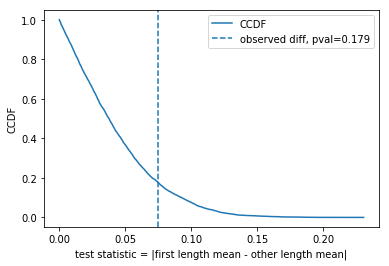

In [19]:
# Hypothesis test for differences in mean pregnancy length.
# This time using resampling instead of permutation.

# Compute the observed difference in mean pregnancy length.
obs_diff = abs(first.prglngth.mean() - other.prglngth.mean())

# Simulate the PMF and CDF over diffs for the null hypothesis by repeatedly
# splitting *all* birth weights in half and computing the diffs.
iters = 5000
sim_diffs = []
for _ in range(iters):
    a = np.random.choice(live.prglngth, len(first), replace=True)
    b = np.random.choice(live.prglngth, len(other), replace=True)
    sim_diffs.append(abs(a.mean() - b.mean()))

sim_diff_pmf = pd.Series(sim_diffs).value_counts(normalize=True)
sim_diff_cdf = mts.pmf_to_cdf(sim_diff_pmf)

# Compute P-value = CCDF(obs_diff)
pval = mts.cdf_pvalue(sim_diff_cdf, obs_diff)

plt.plot(sim_diff_cdf.index, 1 - sim_diff_cdf.values, label='CCDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('test statistic = |first length mean - other length mean|')
plt.ylabel('CCDF')
plt.legend()
plt.show()

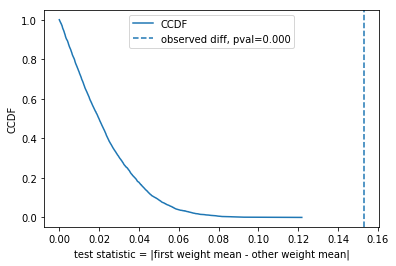

In [20]:
# Hypothesis test for differences in birth weight.
# This time using resampling instead of permutation.

# Compute the observed difference in mean pregnancy length.
live = live.dropna(subset=['birthwgt_lb'])
first = first.dropna(subset=['birthwgt_lb'])
other = other.dropna(subset=['birthwgt_lb'])

obs_diff = abs(first.birthwgt_lb.mean() - other.birthwgt_lb.mean())

# Simulate the PMF and CDF over diffs for the null hypothesis by repeatedly
# splitting *all* birth weights in half and computing the diffs.
iters = 5000
sim_diffs = []
for _ in range(iters):
    a = np.random.choice(live.birthwgt_lb, len(first), replace=True)
    b = np.random.choice(live.birthwgt_lb, len(other), replace=True)
    sim_diffs.append(abs(a.mean() - b.mean()))

sim_diff_pmf = pd.Series(sim_diffs).value_counts(normalize=True)
sim_diff_cdf = mts.pmf_to_cdf(sim_diff_pmf)

# Compute P-value = CCDF(obs_diff)
pval = mts.cdf_pvalue(sim_diff_cdf, obs_diff)

plt.plot(sim_diff_cdf.index, 1 - sim_diff_cdf.values, label='CCDF')
plt.axvline(obs_diff, linestyle='--', label='observed diff, pval=%.3lf' % pval)
plt.xlabel('test statistic = |first weight mean - other weight mean|')
plt.ylabel('CCDF')
plt.legend()
plt.show()

In both cases above, the results seem to be roughly the same. The two sided difference in pregnancy lengths is not significant; the two sided difference in birth weight is significant.

In [21]:
print('Done')

Done
